<a href="https://colab.research.google.com/github/kikekzm/physics-simulations/blob/main/JEZM_Simulaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulación IRM
Jose Enrique Zafra Mena

### Carga de librerias

In [1]:
!git clone https://github.com/JaimeRosado/LegPy.git
import sys
sys.path.insert(0,'/content/LegPy')
import LegPy as lpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install xlsxwriter
import xlsxwriter

Cloning into 'LegPy'...
remote: Enumerating objects: 213, done.
remote: Counting objects: 100% (213/213), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 213 (delta 101), reused 156 (delta 55), pack-reused 0
Receiving objects: 100% (213/213), 1.86 MiB | 5.56 MiB/s, done.
Resolving deltas: 100% (101/101), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 2.7 MB/s eta 0:00:00


# P1
 Para el primer problema haremos colisionar un haz de fotones de $0.5$ MeV a un cilindro de Cobre.

## Código de la simulación

In [2]:
2.7e-4 * 1e6/60

4.5


The simulation has ended

Computing time per beam particle =  1.35e-04 seconds



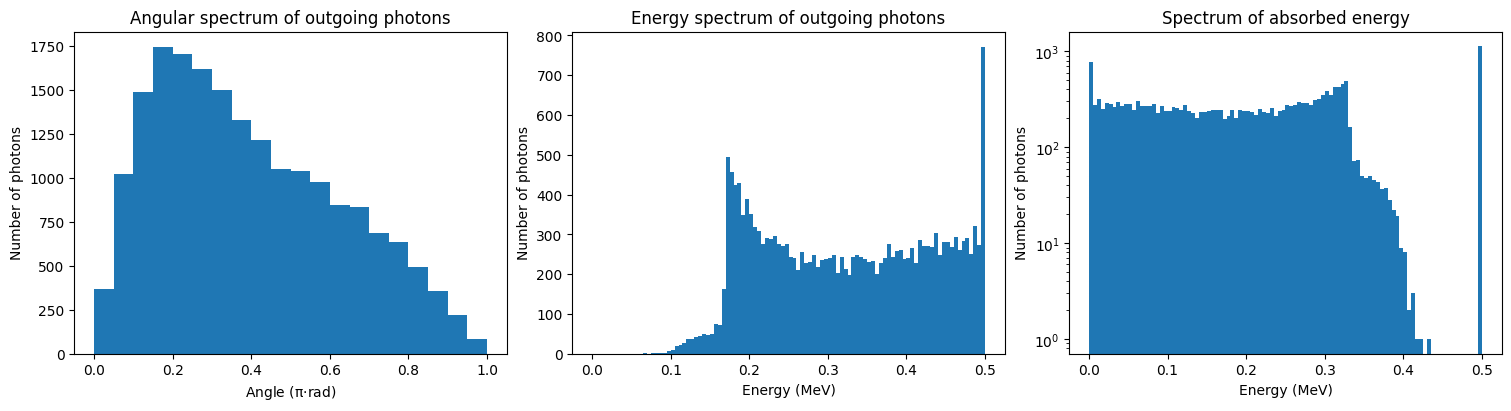

In [9]:
medium = lpy.Medium(name='Cu')
geometry = lpy.Geometry(name='cylinder', diam = 0.3, z = 0.3, n_r=1, n_z=1)
beam = lpy.Beam(name='parallel')
spectrum = lpy.Spectrum(name = 'mono', E = .5)
result = lpy.MC(medium, geometry, spectrum, beam, n_part = int(1e5), n_E = 100)
result.plot_hists()

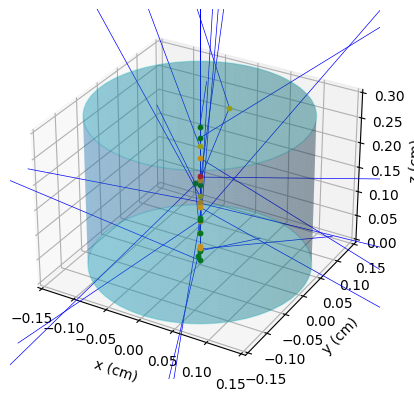

In [13]:
# Podemos ver algunas trayectorias (OPCIONAL)
lpy.Plot_beam(medium, geometry, spectrum, beam, n_part=100, points = True)

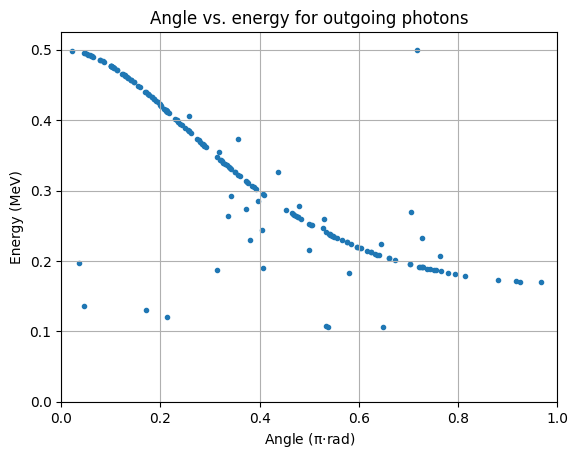

In [14]:
# Podemos ver el espectro angular de algunos fotones (OPCIONAL)
result = lpy.MC(medium, geometry, spectrum, beam, n_part=1000, gamma_out=True)

## Data ETL

In [11]:
# guardamos la distribución angular de los outgoing photons:
ang_df=result.ang_out()
ang_np = ang_df.to_numpy()
# su distribución de energías:
eout_df=result.E_out()
eout_np = eout_df.to_numpy()
# y su energía absorbida:
eabs_df=result.E_ab()
eabs_np = eabs_df.to_numpy()



## a) Comprobación de la fórmula de Klein-Nishina

### Distribución angular
Primero graficamos la sección eficaz de Klein-Nishina en función del ángulo:

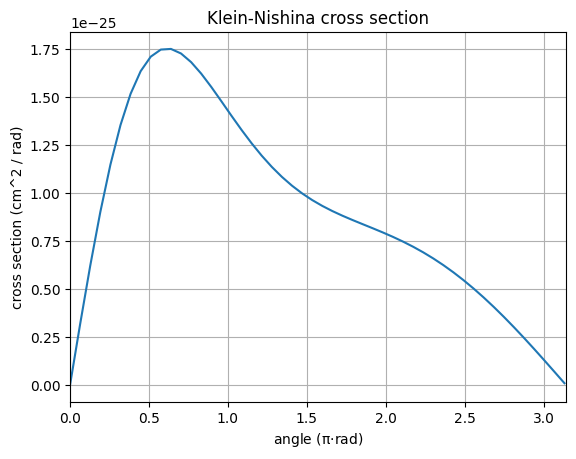

In [7]:
energy = .5
theta = np.linspace(0.0001, np.pi-0.01, 50) # 50 points in the interval 0 - 180 deg.
difa_KN = lpy.axsect_KN(energy, theta) #ds/d(theta)

plt.figure()
plt.plot(theta, difa_KN)
plt.xlabel('angle ('+'\u03C0'+'$\cdot$'+'rad)')
plt.ylabel('cross section (cm^2 / rad)')
plt.xlim(0., np.pi)
plt.title('Klein-Nishina cross section')
plt.grid(True, which = 'both')

Para comparar con los datos de nuestra simulación, primero vamos a dividir las probabilidades de Monte Carlo por la anchura de los bins, de forma que:


*   $\frac{dP}{d\theta}$ en $[rad^{-1}]$
*   $\frac{dP}{d\Omega}$ en $[sr^{-1}]$



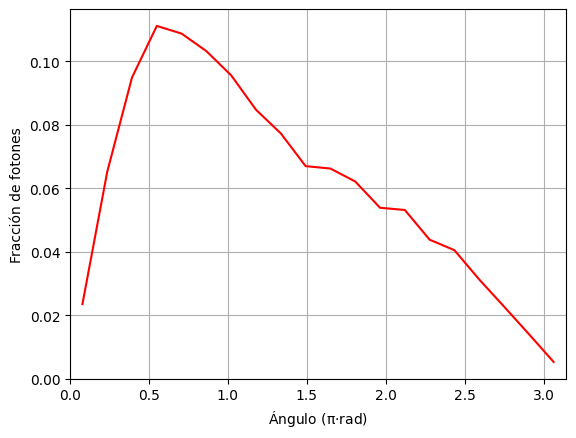

In [12]:
P=ang_np[:,1]
bin_width=ang_np[1,0]-ang_np[0,0]
dP_dtheta=P/(bin_width)

plt.plot(ang_np[:,0],dP_dtheta,'r')
plt.xlabel('Ángulo ('+'\u03C0'+'$\cdot$'+'rad)')
plt.ylabel('Fracción de fotones')
plt.xlim(0., np.pi)
plt.grid(True, which = 'both')
plt.show()

Ahora vamos a graficarlo en la misma figura que el resultado teórico de *Klein-Nishina*. Para ello, tenemos que pasar de probabilidad a secciones eficaces.


Sabemos que la probabilidad de interacción viene dada por $$P=1-\exp{(-N\sigma_{inc}x)}.$$


Como hemos visto también en las clases de teoría, sabemos que podemos aproximar la sección eficaz incoherente como $$\sigma_{inc}\approx Z\sigma_{KN}.$$

Por lo tanto, podemos hallar la sección eficaz de Klein-Nishina (experimental) a partir de las probabilidades como $$\sigma_{KN}\approx \frac{-1}{ZNx}\log{(1-P)},$$
donde


*   $N=\rho N_A/P_A$,
*   $Z$ es el número atómico (para el cobre es 29),
*   y $x$ es el recorrido de la partícula (la longitud del cilíndro).


In [15]:
# creamos una función para pasar de probabilidades a secciones eficaces (solo para la P1):
N_A=6.022e23
Z=29
x=0.3
P_A=63.546
rho=8.96
N=rho*N_A/P_A


def p2s_KN_Cu(p):
  N_A=6.022e23
  Z=29
  x=0.3
  P_A=63.546
  rho=8.96
  N=rho*N_A/P_A
  return -1/(Z*N*x) *np.log(1-p)

def p2s_Cu(p):
  N_A=6.022e23
  Z=29
  x=0.3
  P_A=63.546
  rho=8.96
  N=rho*N_A/P_A
  return -1/(N*x) *np.log(1-p)

sigma_KN=p2s_KN_Cu(dP_dtheta)

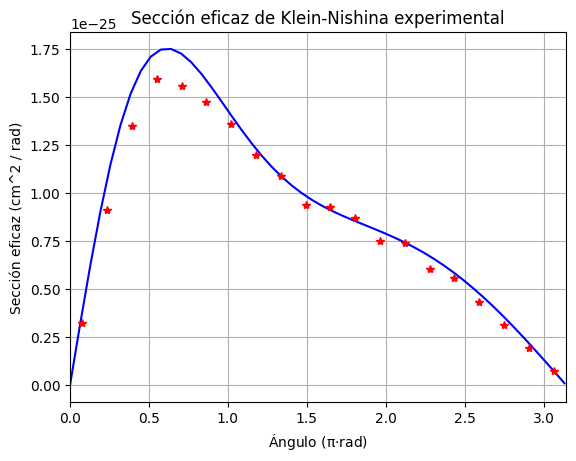

In [16]:
plt.plot(theta, difa_KN,'b')
plt.plot(ang_np[:,0],sigma_KN,'*r')
plt.xlabel('Ángulo ('+'\u03C0'+'$\cdot$'+'rad)')
plt.ylabel('Sección eficaz (cm^2 / rad)')
plt.xlim(0., np.pi)
plt.title('Sección eficaz de Klein-Nishina experimental')
plt.grid(True, which = 'both')

También podemos comparar en un gráfico polar, para lo que usamos la expresión $$\frac{d\sigma}{d\Omega}=\frac{1}{2\pi\sin(\theta)}\frac{d\sigma}{d\theta}.$$

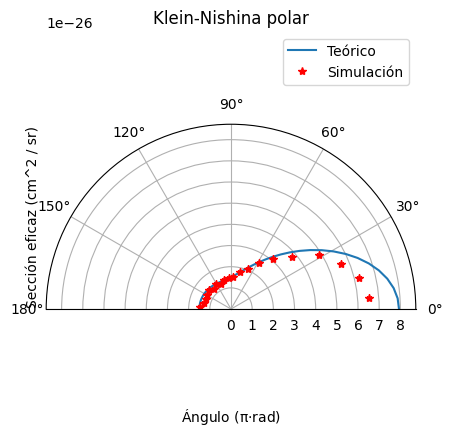

In [17]:
plt.figure()
plt.polar(theta, difa_KN/(2*np.pi*np.sin(theta)),label='Teórico')
plt.polar(ang_np[:,0], sigma_KN/(2*np.pi*np.sin(ang_np[:,0])),'*r',label='Simulación')

plt.xlabel('Ángulo ('+'\u03C0'+'$\cdot$'+'rad)')
plt.ylabel('Sección eficaz (cm^2 / sr)')
plt.xlim(0., np.pi)
plt.ylim(0., 1.1 * np.amax(difa_KN/(2*np.pi*np.sin(theta))))
plt.title('Klein-Nishina polar')
plt.legend()
plt.grid(True, which = 'both')

Podemos ver, cualitativamente, que los datos de la simulación siguen muy bien la curva experimental. \\

Cuando la dispersión es de $\sim 0$°, vemos que los datos difieren. Esto puede ser debido a que a esos ángulos la dispersión incoherente ya no es la dominante.



#### Distribución de energía de los electrones

Siguiendo con la teoría de Klein-Nishina, vamos a ver la distribución energética de la sección eficaz teórica:

Energía del borde Compton =  0.3309066843150232  MeV


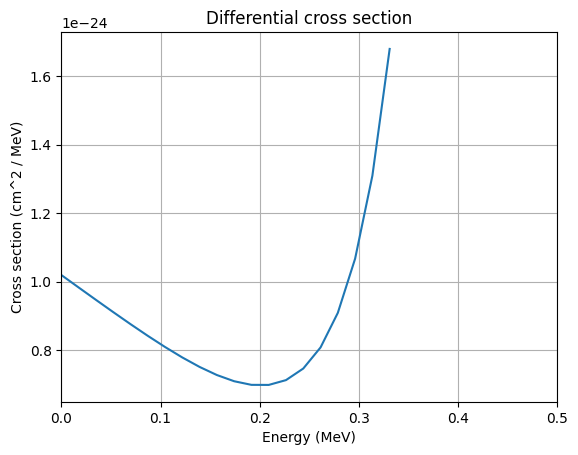

In [18]:
## Theory (from the Klein-Nishina xsection)
gamma = energy / .511
eCe = energy * (2 * gamma / (1 + 2 * gamma))
eener = np.linspace(0.000, eCe, 20) # 100 points in the interval 0 - photon energy
dife_KN = lpy.exsect_KN(energy, eener) #ds/d(energy)
#
plt.figure(1)
plt.plot(eener, dife_KN)
plt.xlabel('Energy (MeV)')
plt.ylabel('Cross section (cm^2 / MeV)')
plt.xlim(0., energy)
#plt.ylim(0.1, 1.1 * np.amax(Pe_mc_n))
plt.title('Differential cross section')
plt.grid(True, which = 'both')
print('Energía del borde Compton = ',eCe, ' MeV')

Ahora vamos a ver la distribución de energía absorbida por los electrones:

<ipython-input-15-0a60d4393520>:17: RuntimeWarning: invalid value encountered in log
  return -1/(Z*N*x) *np.log(1-p)


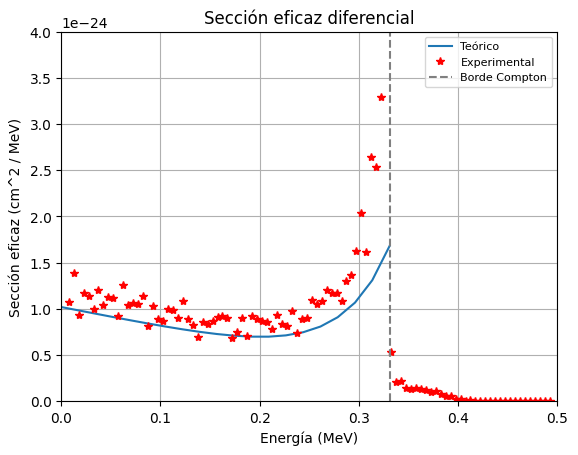

In [19]:
# queremos obtener dP/dE en 1/MeV.
dP_dE=eabs_np[:,1]/(abs(eabs_np[1,0]-eabs_np[0,0]))

# lo pasamos de probabilidades a secciones eficaces.
sigma_E=p2s_KN_Cu(dP_dE)

# representación gráfica
plt.plot(eener, dife_KN, label='Teórico')
plt.plot(eabs_np[:,0],sigma_E,'r*', label='Experimental')
plt.xlabel('Energía (MeV)')
plt.ylabel('Sección eficaz (cm^2 / MeV)')
plt.xlim(0., energy)
plt.ylim(0,4e-24)
plt.title('Sección eficaz diferencial')
plt.grid(True, which = 'both')
plt.vlines(eCe,0, 1,'gray',ls='--', label='Borde Compton')
plt.legend(fontsize=8)
plt.show()

In [20]:
# Además, vamos a ver donde está el borde Compton experimental:

# quitamos los valores NaN del array para trabajar mejor:
indices_nan= np.isnan(sigma_E)
sigma_E_nn=sigma_E[~indices_nan]
eabs_np_nn= eabs_np[~indices_nan,1]
# hallamos el máximo de la sección eficaz,
sigma_max=sigma_E_nn.max()
# hallamos su posición en el array,
i=np.where(sigma_E_nn==sigma_max)[0][0]
# en esa posición para el array de energías está el borde Compton:
E_borde= eabs_np[i,0]
print('Energía del borde Compton = ', E_borde, 'MeV')
print('Error relativo = ',100* abs(E_borde-eCe)/eCe, '%')

Energía del borde Compton =  0.32249999999999995 MeV
Error relativo =  2.5405000000000193 %


Hay cierta discrepancia entre los datos de la simulación y lo esperado por la teoría. En general, las secciones eficaces experimentales son superiores, y a medida que nos acercamos al borde Compton, son incluso más grandes.

Aún así, el error relativo de la posición del borde Compton es muy pequeño: tan solo $\delta = 2.54\%$.

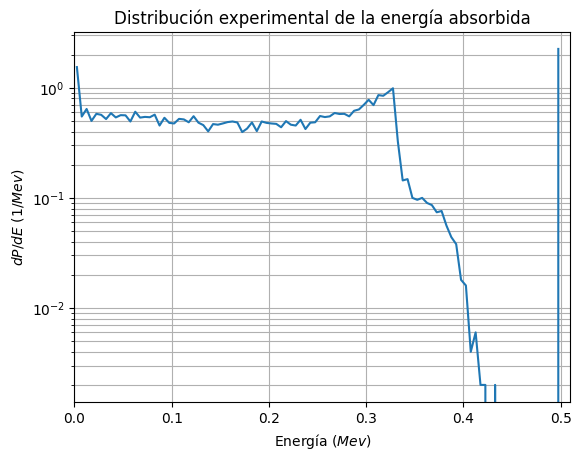

In [23]:
Ep=np.linspace(0,energy,1000)

plt.plot(eabs_np[:,0],dP_dE)
plt.xlabel('Energía ' +'($Mev$)')
plt.ylabel('$dP/dE$ ' + '($1/Mev$)')
plt.xlim([0,0.51])
plt.yscale('log')
plt.title('Distribución experimental de la energía absorbida')
plt.grid(True, which = 'both')
plt.show()

En la gráfica superior podemos observar un borde Compton algo difuminado, cerca de unos $\sim 0.3\ MeV$. Este borde no es tan pronunciado como en un caso ideal ya que no toda la energía se absorbe solo por efecto Compton, si no también por scattering incoherente.

Además podemos observar la línea vertical en $0.5\ MeV$ correspondiente a los fotones absorbidos por efecto Fotoeléctrico; y los fotones que no son absorbidos debido a la dispersión coherente en la zona de $E\sim 0 MeV$.

### Comparación de los histogramas

Vamos a ver primero cómo se distribuyen los electrones salientes en función de la energía,

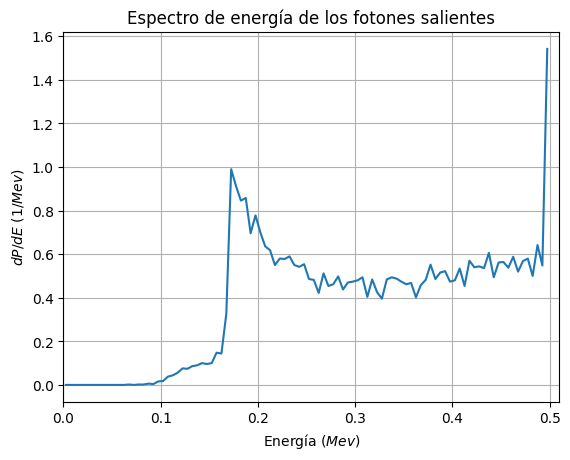

In [24]:
# primero hallamos la fración de fotones:
dP_dE_out=eout_np[:,1]/(abs(eout_np[1,0]-eout_np[0,0]))

Ep=np.linspace(0,energy,1000)

plt.plot(eout_np[:,0],dP_dE_out)
plt.xlabel('Energía ' +'($Mev$)')
plt.ylabel('$dP/dE$ ' + '($1/Mev$)')
plt.xlim([0,0.51])
#plt.yscale('log')
plt.title('Espectro de energía de los fotones salientes')
plt.grid(True, which = 'both')
plt.show()

En la gráfica anterior podemos ver un pico antes de llegar a $0.2$ MeV. Este pico es el correspondiente al borde Compton: los fotones entran con $0.5$ MeV, ceden la energía del borde Compton a un electrón, y finalmente salen con una energía de $E_{disp}=(0.5-0.32)MeV=0.18\ MeV$.

Además, podemos ver el pico de $0.5\ MeV$ correspondiente a los fotones dispersados por scattering coherente.

Por último, se puede apreciar que la zona entre $0$ y $E_{disp}$, aunque idealmente debería de ser $0$, no es así debido principalmente a que en la simulación es posible que un fotón interactúe varias veces antes de salir del medio.

## b) Cálculo de las secciones eficaces

En primer lugar, vamos a obtener lo coeficientes de atenuación coherente, incoherente y fotoeléctrico.

In [28]:
# Coeficiente de atenuación Coherente:
mu_coh= N*p2s_Cu((abs(eabs_np[0,1]-eabs_np[1,1])))
mu_coh_masico= mu_coh/rho

# Coficientes de atenuación Incoherente:
mu_inc= N*p2s_Cu(sum(eabs_np[1:-1,1]))
mu_inc_masico=mu_inc/rho

# Coeficientes de atenuación Fotoeléctrico:
mu_ph= N*p2s_Cu(eabs_np[-1,1])
mu_ph_masico=mu_ph/rho

print('mu_coh_masico =',mu_coh_masico)
print('mu_inc_masico =',mu_inc_masico)
print('mu_ph_masico =',mu_ph_masico)

mu_coh_masico = 0.0018535682754093406
mu_inc_masico = 0.07591675027999874
mu_ph_masico = 0.004216513268193395


Ahora tenemos que comparar estos valores con los teóricos.

In [34]:
medium = lpy.Medium(name='Cu')
mu_coh_teor = medium.ph_data.Mu_Coh_Cross_section(energy)
mu_inc_teor = medium.ph_data.Mu_Inc_Cross_section(energy)
mu_ph_teor = medium.ph_data.Mu_Phot_Cross_section(energy)

###
print('Error relativo en mu_coh = ', round(100*abs(mu_coh_teor-mu_coh_masico)/mu_coh_teor, 1),'%')
print('Error relativo en mu_inc = ', round(100*abs(mu_inc_teor-mu_inc_masico)/mu_inc_teor,2),'%')
print('Error relativo en mu_ph = ', round(100*abs(mu_ph_teor-mu_ph_masico)/mu_ph_teor,1),'%')

Error relativo en mu_coh =  10.4 %
Error relativo en mu_inc =  3.89 %
Error relativo en mu_ph =  64.2 %


Los errores relativos son altos para $\mu_{coh}$ y para $\mu_{ph}$. Esto puede ser debido al bajo número de fotones que sufren dichos procesos: el que tiene mayor muestra es el scattering incoherente.

# P2


Ahora vamos a tener un material de Plomo al que le aplicamos un haz de fotones de $1\ MeV$.

In [35]:
medium = lpy.Medium(name='Pb')
beam = lpy.Beam(name='parallel')
spectrum = lpy.Spectrum(name = 'mono', E = 1.)
geometry = lpy.Geometry(name='cylinder', diam = 0.002, z = 10., n_r=1, n_z=50)
result = lpy.MC(medium, geometry, spectrum, beam, n_part = int(1e5), n_E = 100)


The simulation has ended

Computing time per beam particle =  1.62e-04 seconds



Ahora tratamos los datos,

In [36]:
Edep_df = result.Edep_to_df()

# guardamos la distribución angular de los outgoing photons:
ang_df=result.ang_out()
ang_np = ang_df.to_numpy()
# su distribución de energías:
eout_df=result.E_out()
eout_np = eout_df.to_numpy()
# y su energía absorbida:
eabs_df=result.E_ab()
eabs_np = eabs_df.to_numpy()

## a) Cálculo del coeficiente de atenuación

Primero tenemos que extraer los datos a utilizar y crear una función para el ajuste:

In [37]:
# Extraer los datos de Edep(z)
N = Edep_df.size
z_val = np.reshape(Edep_df.index, (N)) # values of z
E_val = np.reshape(Edep_df.values, (N)) # values of Edep

# Exponential fit
from scipy import optimize

def test_func(x, a, b):
    return a * np.exp(-b * x)

Podemos hacer el ajuste como:

In [38]:
# with initial guess
# a rough estimate of a, b
p0b = np.log(E_val[0]/E_val[-1]) / (z_val[-1] - z_val[0])
p0a = E_val[0] * np.exp(p0b * z_val[0])

params, params_covariance = optimize.curve_fit(test_func, z_val, E_val, p0=[p0a, p0b])
mu_tot = params[1]
edep_0 = params[0]
print('\u03BC = ',"{:.2e}".format(mu_tot), '1/cm', '   (from exponential attenuation)')
print('Edep(0) ', "{:.2e}".format(edep_0), 'keV/photon/cm3')

μ =  8.02e-01 1/cm    (from exponential attenuation)
Edep(0)  1.45e+08 keV/photon/cm3


Con esto podemos representar el ajuste:

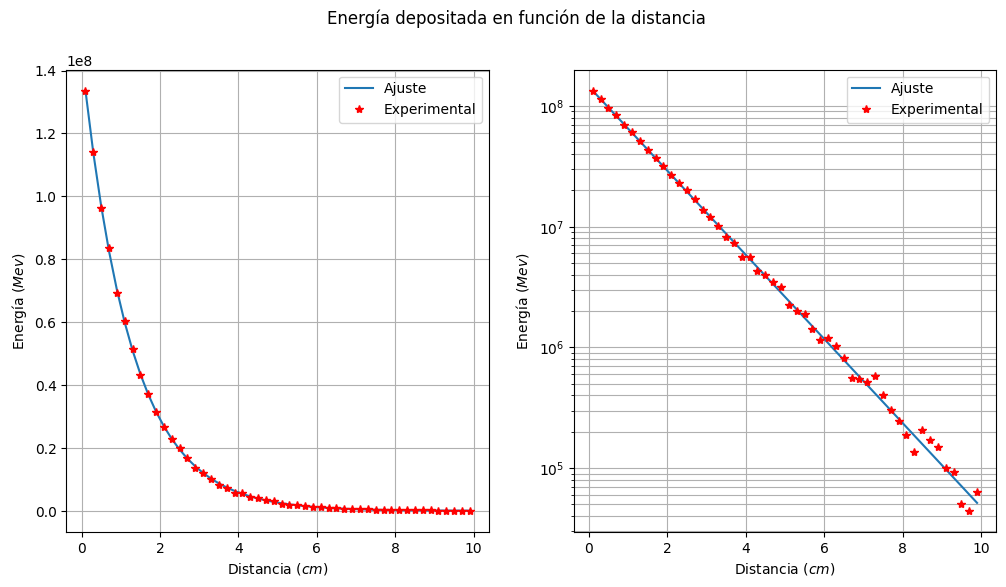

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle('Energía depositada en función de la distancia')

axs[0].plot(z_val, test_func(z_val, edep_0, mu_tot), label='Ajuste')
axs[0].plot(z_val,E_val,'*r',label='Experimental')
axs[0].set_xlabel('Distancia ' +'($cm$)')
axs[0].set_ylabel('Energía ' + '($Mev$)')
axs[0].grid(True, which = 'both')
axs[0].legend()

axs[1].plot(z_val, test_func(z_val, edep_0, mu_tot), label='Ajuste')
axs[1].plot(z_val,E_val,'*r',label='Experimental')
axs[1].set_yscale('log')
axs[1].set_xlabel('Distancia ' +'($cm$)')
axs[1].set_ylabel('Energía ' + '($Mev$)')
axs[1].grid(True, which = 'both')
axs[1].legend()

plt.show()

Los datos experimentales siguen muy bien la curva teórica. En la representación logarítmica podemos ver que al acercarse al final del recorrido, hay algo de ruido. Esto se debe de nuevo al bajo número de fotones que llegan tan lejos.

## b) Verificando Klein-Nishina

Procedemos con en P1. Vamos a representar la distribución angular de Klein-Nishina teórica junto con la obtenida en la simulación. Para esto necesitamos hallar probabilidad de la dispersión incoherente, para lo que usaremos:
$$\mu=N\sigma \longrightarrow P=1-e^{-\mu z}\longrightarrow P_{inc}=(1-e^{-\mu z})\frac{\sigma_{inc}}{\sigma}\approx (1-e^{-\mu z})\frac{ZN}{\mu}\sigma_{KN}. $$

A partir de esta expresión, se obtiene inmediatamente la siguiente ecuación:

$$\frac{d\sigma_{KN}}{d\theta}=\frac{\mu}{ZN(1-e^{-\mu z})}\frac{dP_{inc}}{d\theta}$$

In [44]:
# creamos una función para pasar de probabilidades a secciones eficaces para el Plomo
N_A=6.022e23
Z=82
x=10
P_A=207.2
rho=11.34
N=rho*N_A/P_A

def p2s_Pb(p):
  return mu_tot/(Z*N*(1-np.exp(-mu_tot*x)))*p

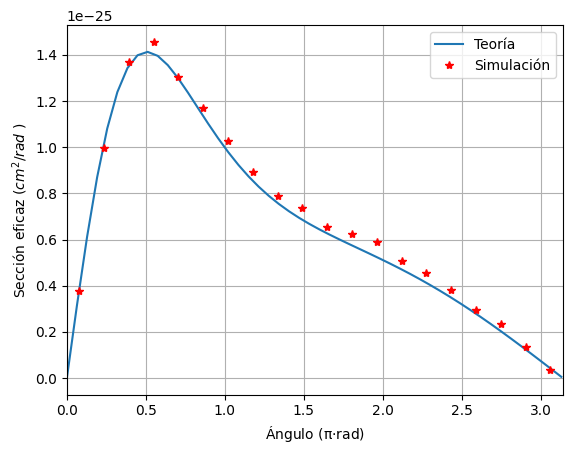

In [45]:
# primero hallamos la distribución de la simulación,
P=ang_np[:,1]
bin_width=ang_np[1,0]-ang_np[0,0]
dP_dtheta=P/(bin_width)
sigma_KN=p2s_Pb(dP_dtheta)

energy =  1.
theta = np.linspace(0.0001, np.pi-0.01, 50)
difa_KN = lpy.axsect_KN(energy, theta)

plt.plot(theta, difa_KN, label='Teoría')
plt.plot(ang_np[:,0],sigma_KN,'*r', label='Simulación')
plt.xlabel('Ángulo ('+'\u03C0'+'$\cdot$'+'rad)')
plt.ylabel('Sección eficaz ('+'$cm^2/rad$ '+')')
plt.xlim(0., np.pi)
plt.grid(True, which = 'both')
plt.legend()
plt.show()

Para la represantación polar, procedemos como en el P1, y obtenemos la siguiente relación:

$$\frac{d\sigma_{KN}}{d\Omega}=\frac{1}{2\pi\sin{\theta}}\frac{d\sigma_{KN}}{d\theta}.$$

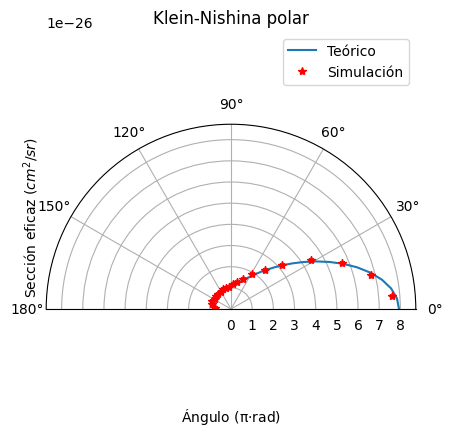

In [46]:
plt.figure()
plt.polar(theta, difa_KN/(2*np.pi*np.sin(theta)),label='Teórico')
plt.polar(ang_np[:,0], sigma_KN/(2*np.pi*np.sin(ang_np[:,0])),'*r',label='Simulación')

plt.xlabel('Ángulo ('+'\u03C0'+'$\cdot$'+'rad)')
plt.ylabel('Sección eficaz '+'($cm^2 / sr$)')
plt.xlim(0., np.pi)
plt.ylim(0., 1.1 * np.amax(difa_KN/(2*np.pi*np.sin(theta))))
plt.title('Klein-Nishina polar')
plt.legend()
plt.grid(True, which = 'both')

Por último, para ver la relación con la energía, usamos la expresión:

$$\frac{d\sigma_{KN}}{dE}=\frac{\mu}{ZN(1-e^{-\mu z})}\frac{dP_{inc}}{dE}.$$

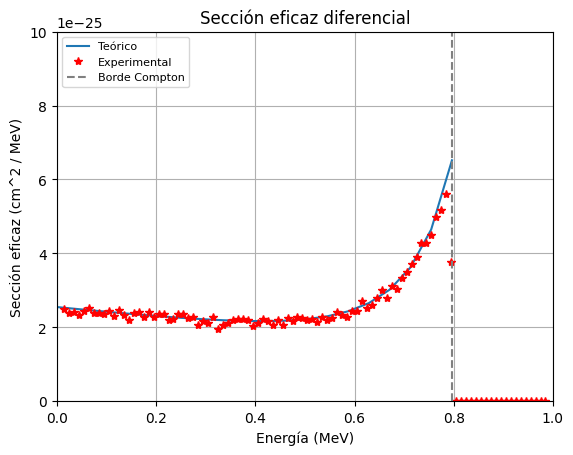

In [51]:
# queremos obtener dP/dE en 1/MeV.
dP_dE=eabs_np[:,1]/(abs(eabs_np[1,0]-eabs_np[0,0]))

# lo pasamos de probabilidades a secciones eficaces.
sigma_E=p2s_Pb(dP_dE)
energy=1
## Theory (from the Klein-Nishina xsection)
gamma = energy / .511
eCe = energy * (2 * gamma / (1 + 2 * gamma))
eener = np.linspace(0.000, eCe, 20) # 100 points in the interval 0 - photon energy
dife_KN = lpy.exsect_KN(energy, eener) #ds/d(energy)

# representación gráfica
plt.plot(eener, dife_KN, label='Teórico')
plt.plot(eabs_np[:,0],sigma_E,'r*', label='Experimental')
plt.xlabel('Energía (MeV)')
plt.ylabel('Sección eficaz (cm^2 / MeV)')
plt.xlim(0., energy)
plt.ylim(0,1e-24)
plt.title('Sección eficaz diferencial')
plt.grid(True, which = 'both')
plt.vlines(eCe,0, 1,'gray',ls='--', label='Borde Compton')
plt.legend(fontsize=8)
plt.show()

En este problema conseguimos mejores resultados experimentales que en el anterior. Esto se debe principalmente a que estamos aplicando un haz de fotones de mayor energía, por lo que la aproximación $\sigma_{inc}\approx Z\sigma_{KN}$ es mejor.

### Cálculo de las secciones eficaces

Para hallar las secciones eficaces de cada proceso usamos de nuevo la expresión
$$P_i=(1-e^{-\mu z})\frac{\sigma_i}{\sigma},$$
que teniendo en cuenta que $\mu=N\sigma$, podemos finalmente reescribir:

$$\sigma_i=\frac{\mu P_i}{N(1-e^{-\mu z})}.$$

In [55]:
# definimos una función que usaremos:
N_A=6.022e23
Z=82
x=10
P_A=207.2
rho=11.34
N=rho*N_A/P_A

def prob2sect(P):
  mu=mu_tot
  z=10
  return mu*P/(N*(1-np.exp(-mu*z)))

In [59]:
# primero hallamos las probabilidades de cada proceso:
prob_coh= abs(eabs_np[0,1]-eabs_np[1,1])
prob_inc= sum(eabs_np[1:-1,1])
prob_ph= eabs_np[99,1]

# ahora las secciones eficaces
sigma_coh= prob2sect(prob_coh)
sigma_inc= prob2sect(prob_inc)
sigma_ph= prob2sect(prob_ph)

# y con éstas los coefs. de atenuación (MÁSICOS)
mu_coh=N*sigma_coh/rho
mu_inc=N*sigma_inc/rho
mu_ph=N*sigma_ph/rho

# hallamnos los valores teóricos:
medium = lpy.Medium(name='Pb')
mu_coh_teor = medium.ph_data.Mu_Coh_Cross_section(energy)
mu_inc_teor = medium.ph_data.Mu_Inc_Cross_section(energy)
mu_ph_teor = medium.ph_data.Mu_Phot_Cross_section(energy)


###
print('Error relativo en mu_coh = ', round(100*abs(mu_coh_teor-mu_coh)/mu_coh_teor,2),'%')
print('Error relativo en mu_inc = ', round(100*abs(mu_inc_teor-mu_inc)/mu_inc_teor,2),'%')
print('Error relativo en mu_ph = ', round(100*abs(mu_ph_teor-mu_ph)/mu_ph_teor,3),'%')

Error relativo en mu_coh =  4.47 %
Error relativo en mu_inc =  1.73 %
Error relativo en mu_ph =  0.563 %


En este apartado obtenemos también mejores resultados que en el problema anterior.

Al estar usando un elemento más pesado (mayor Z) y mayor energía de haz, el scattering incoherente no es tan dominante: de la teoría sabemos que alrededor de los $\approx 0.6\ MeV$ (para este material) el efecto fotoeléctrico es el dominante. Por tanto tenemos mayor muestra de fotones que sufren dispersión coherente y efecto fotoeléctrico, y con ello obtenemos menor error en sus coeficientes de atenuación másicos.
